In [ ]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python38_MacOS64')
import pygplates

from collections import defaultdict

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm
import matplotlib as mpl

import glob
import os

In [ ]:
#sort files in a folder
#sort numerically because glob doens't >.>
import re

#turn a string of numbers in a file name into integers
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s

#split a filename into alpha and numerical components
def alphanum_key(s):
    return [tryint(c) for c in re.split('([0-9]+)', s)]

def sort_nicely(l):
    return sorted(l, key=alphanum_key)

In [34]:
def sum_results(dataframe):
    
    '''
This function takes the dataframe and calculates seafloor production
from two of the columns and then sums for each timestep.

Returns: Pandas dataframe of two columns:
            1) Seafloor production (km2)
            2) Time (Ma)

    '''
    #set timerange
    times = np.arange(dataframe['Time_Ma'].min(),
                      dataframe['Time_Ma'].max()+1,
                      1)
    #set empty array for results
    seafloor_production = np.zeros(np.shape(times))
    mean_spreading_rate = np.zeros(np.shape(times))
    total_length = np.zeros(np.shape(times))
    
    #loop through times
    for ind, time in enumerate(times):

        #get just the entries from the timestep
        tmp_df = dataframe.loc[dataframe['Time_Ma'] == time]
        
        #plate velocity in cm/a, * 10 for mm/a or km/Ma
        tmp_plate_velocity = tmp_df['Plate_Velocity'] * 10
        #length of segment in km
        tmp_length = tmp_df['Length_km']
        
        #get production at timestep
        tmp_prod = np.sum(tmp_plate_velocity * tmp_length)
        #get mean spreading rate
        tmp_mean_spreading_rate = np.mean(tmp_plate_velocity)
        #get total ridge length
        tmp_total_length = np.sum(tmp_length)

        seafloor_production[ind] = tmp_prod
        mean_spreading_rate[ind] = tmp_mean_spreading_rate
        total_length[ind] = tmp_total_length
        
    #convert to dataframe
    seafloor_produciton_df = pd.DataFrame({'Time_(Ma)': times,
                                           'Seafloor_prod_(km2)': seafloor_production,
                                           'Ridge_length_(km)': total_length,
                                           'Mean_spreading_rate_(km/Ma)':mean_spreading_rate
                                          },

                               columns=['Time_(Ma)',
                                        'Seafloor_prod_(km2)',
                                        'Ridge_length_(km)',
                                        'Mean_spreading_rate_(km/Ma)'])
    return seafloor_produciton_df

In [6]:
#set directories
datadir = '/Users/andrew/Documents/Data/plate_boundary_analysis/'
platedir = '/Users/andrew/Documents/GitHub/EarthBytePlateMotionModel-ARCHIVE/Muller++_2015_AREPS_CORRECTED/'
savedir = '/Users/andrew/Documents/Data/Gernon_shallow_ridges/'
# import previously made file in 'extract velocities'
file = '%sPlateBoundaryTypes_400-0_25Oct19.h5' % datadir
df = pd.read_hdf(file,'Statistics_table')
tags = df['FeatureType']

rotfile = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS.rot' % platedir
COBs = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml' % platedir
coastlines = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml' % platedir
input_topology_filename = ['%sGlobal_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml' % platedir,
                           '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml' % platedir]

rotation_model = pygplates.RotationModel(rotfile)


In [7]:
#get our mid-ocean ridge spreading segments
deviation_angle = 70
MOR_subset = df[(df['FeatureType']=='gpml:MidOceanRidge')
             & (np.abs(df['Deviation_mod_deg'])<=deviation_angle)]
#reset_index
MOR_subset = MOR_subset.reset_index(drop=True)

In [8]:
#define mean lat and lon as we will use these points to test against
#our polygons
MeanPointLat = MOR_subset[['EndPointLat', 'StartPointLat']].mean(axis=1)
MeanPointLon = MOR_subset[['EndPointLon', 'StartPointLon']].mean(axis=1)

#intsert into our dataframe at the start.
#Lon needs to be 0 and Lat needs to 1 for gmt select, so lat then lon
MOR_subset. insert(0, 'MeanPointLat', MeanPointLat)
MOR_subset.insert(0, 'MeanPointLon', MeanPointLon)

In [9]:
#gmt select doesn't seem to work with strings, so drop unneeded columns
MOR_subset = MOR_subset.drop(columns=['FeatureType', 
                                      'Name', 
                                      'Valid_time', 
                                      'Deviation',
                                      'Deviation_mod_deg',
                                      'StagePole_rad'])

#save all results to csv
MOR_subset.to_csv('%sresults/MOR_spreading_segments_GLOBAL.csv' % savedir,
                  sep=',', index=False, header=True)

In [10]:
#now need to save individual timesteps
for time in np.arange(0, 231, 1):
    tmp_df =  MOR_subset[(MOR_subset['Time_Ma'] == time)]
    tmp_df.to_csv('%s/timestep_tables/%s_Ma_GLOBAL.csv' % (savedir, time),
                  index=False,
                  header=False)
#need to save headers for later
headers = list(tmp_df.columns)

In [11]:
#do shell stuff, select_bounds.sh
#the script creates empty files which we just remove here
os.chdir('%sridge_polygons/csv_results/' % savedir)
fileList=glob.glob('*.csv')

for filename in fileList:
    if os.stat(filename).st_size==0:
        os.remove(filename)

In [12]:
#define our geographical regions
files = ['Afr-Mad', 'Aus-Ant', 'Aus-Mol', 'Central_Atlantic', 
         'Equatorial_Atlantic', 'Iberian_Atlantic', 'Ind-Aus-Ant','Ind-Mad', 
         'Labrador_sea', 'North_Atlantic', 'Southern_Atlantic']


In [35]:
#organise all results back into a single file, of raw and summed data

#for all data
tmp_global_frame = []
#loop through files (i.e. geographic regions)
for file in files:
    all_files = glob.glob('%sridge_polygons/csv_results/' % savedir + str(file) + '*' )
    sorted_files = sort_nicely(all_files)
    li = []
    
    #loop through sorted files and open as dfs, then append to a list
    for filename in sorted_files:
        #print(filename)
        #skip empty ones
        if os.path.getsize(filename) == 0:
            print('empty', filename)
            df = pd.DataFrame()

        else:
            df = pd.read_csv(filename, index_col=None, header=None, delim_whitespace=True, names=headers)
        li.append(df)

    #concat region files into one df
    rift_frame = pd.concat(li, axis=0, ignore_index=True)
    #save to csv
    rift_frame.to_csv('%sresults/raw_shallow_spreading_segments_%s.csv' % (savedir, str(file)), 
                      sep=',', index=False, header=True)

    #sum results of each region per timestep
    summed_results = sum_results(rift_frame)
    #save to csv
    summed_results.to_csv('%sresults/summed_shallow_spreading_segments_%s.csv' % (savedir, str(file)), 
                      sep=',', index=False, header=True)
    
    #append raw results to global frame
    tmp_global_frame.append(rift_frame)
#concat all results
global_frame = pd.concat(tmp_global_frame, axis=0, ignore_index=True)
#save to csv
global_frame.to_csv('%sresults/raw_shallow_spreading_segments_GLOBAL.csv' % savedir, 
                      sep=',', index=False, header=True)
#sum global results per timestep
full_summed_results = sum_results(global_frame)
#save to csv
full_summed_results.to_csv('%sresults/summed_shallow_spreading_segments_GLOBAL.csv' % savedir, 
                      sep=',', index=False, header=True)


0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400


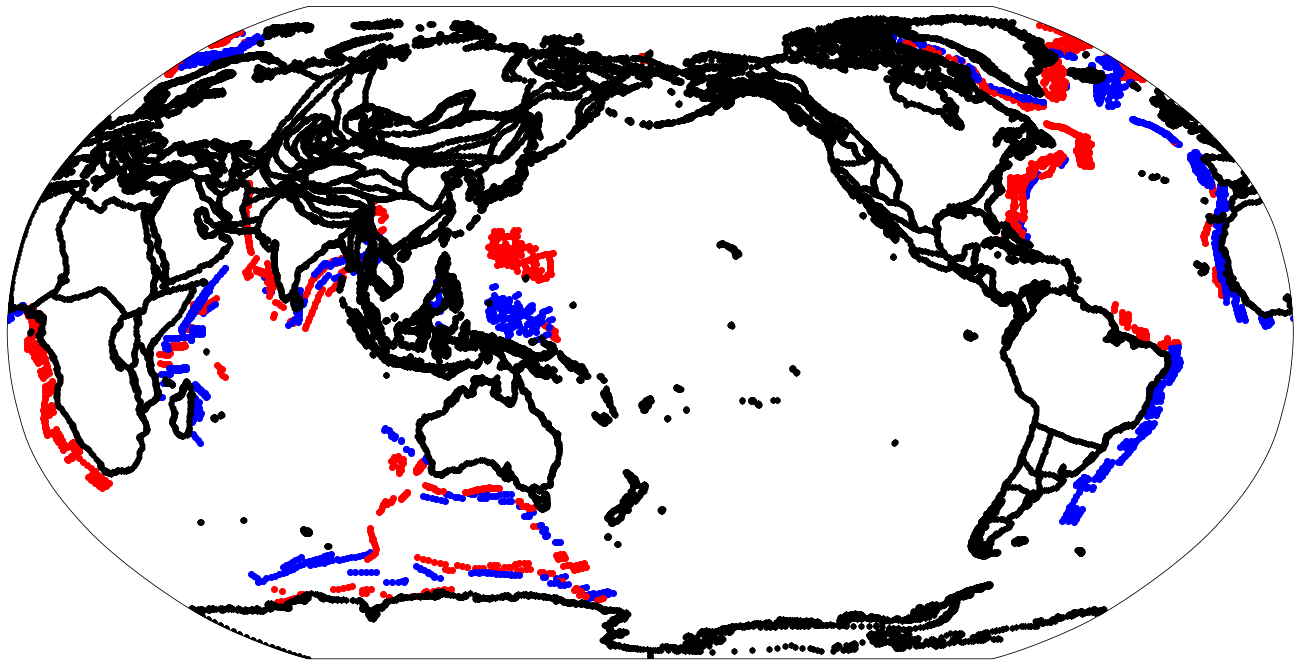

In [14]:
#plotting (but cartopy still broken?)
data_crs = ccrs.PlateCarree()
poly_data_crs = ccrs.PlateCarree()
date_line_wrapper = pygplates.DateLineWrapper(180) 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),subplot_kw={'projection': ccrs.Robinson(180)})
reconstructed_coastlines = []
pygplates.reconstruct(coastlines,rotation_model,reconstructed_coastlines,0)


for ind, row in global_frame.iterrows():
    if ind % 10 != 0:
        continue
    if ind % 200 == 0:
        print(ind)
    points = np.array([row[2], row[3], row[4], row[5]])
    point = np.array([row[1], row[0]])
    polyline = pygplates.PolylineOnSphere(zip(points[::2],points[1::2]))
    mid_point = pygplates.PointOnSphere(point)
    left_plate = row[7]
    right_plate = row[8]
    time = row[10]
    rotation_right = rotation_model.get_rotation(0, int(right_plate), int(time))
    rotation_left = rotation_model.get_rotation(0, int(left_plate), int(time))
    reconstructed_line_right = rotation_right * polyline
    reconstructed_line_left = rotation_left * polyline

    wrapped_line_left = date_line_wrapper.wrap(reconstructed_line_left, 1)
    for wrapped_line in wrapped_line_left:
        wrapped_lat_left = []
        wrapped_lon_left = []
        for point in wrapped_line.get_points():
            wrapped_lat_left.append(point.get_latitude())
            wrapped_lon_left.append(point.get_longitude())

        ax.scatter(wrapped_lon_left, wrapped_lat_left,
                   c='red', transform=poly_data_crs)

    wrapped_line_right = date_line_wrapper.wrap(reconstructed_line_right, 1)
    for wrapped_line in wrapped_line_right:
        wrapped_lat_right = []
        wrapped_lon_right = []
        for point in wrapped_line.get_points():
            wrapped_lat_right.append(point.get_latitude())
            wrapped_lon_right.append(point.get_longitude())

        ax.scatter(wrapped_lon_right,wrapped_lat_right,
                   c='blue', transform=poly_data_crs)

for coastline in reconstructed_coastlines:
    coastline_geom = pygplates.PolygonOnSphere(coastline.get_reconstructed_geometry())
    wrapped_coastlines = date_line_wrapper.wrap(coastline_geom, 1)
    for wrapped_coastline in wrapped_coastlines:
        wrapped_coastlines_lat = []
        wrapped_coastlines_lon = []
        for wrapped_coastline_point in wrapped_coastline.get_exterior_points():
            wrapped_coastline_lat_lon = wrapped_coastline_point.get_latitude(), wrapped_coastline_point.get_longitude()
            wrapped_coastlines_lat.append(wrapped_coastline_point.get_latitude())
            wrapped_coastlines_lon.append(wrapped_coastline_point.get_longitude())
        ax.scatter(wrapped_coastlines_lon, wrapped_coastlines_lat, color='k', lw=0.01, transform=data_crs)


In [ ]:
frame